## Detection of Malicious Accounts on Azure-AD signon using Relational Graph Neural Network (RGCN)

### Content
1. Introduction
2. Dataset Loading & Precessing
3. Graph construction
4. Training
5. Evaluation
6. Summary

### 1. Introduction

Azure active directory (Azure-AD) is an identity and access management service, that helps users to access external and internal resources such as Office365, SaaS applications. The Sign-in logs in Azure-AD log identifies who the user is, how the application is used for the access and the target accessed by the identity [1]. On a given time 𝑡, a service 𝑠 is requested by user 𝑢 from device 𝑑 using authentication mechanism of 𝑎 to be either allowed or blocked.

This workflow shows end-to-end pipeline for azure malicious sign-in malicious detection using relational graph neural network (RGCN).

In [53]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
import dgl
import dgl.nn.pytorch as dglnn
import numpy as np
import dgl.function as fn
import pickle
from utils import *
import logging
from sklearn.metrics import roc_auc_score, accuracy_score
from model import HeteroRGCN, save_model
from tqdm import tqdm, trange
from data_processing import   build_azure_graph, get_anonomized_dataset, synthetic_azure

from xgboost import XGBClassifier
from utils import get_metrics
from model_training import init_loaders, train, evaluate


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



### Dataset Loading and Processing
Load dataset and set true fraud label for the testing and status flag for training. Define set of meta columns to exclude as training features. 

In [54]:
status_label = 'status_flag'
result_dir = 'azure_result'

## uncomment the two lines for running on preprocessed anonomized dataset
meta_cols = ['day',
'fraud_label','appId_id','userId_id','ipAddress_id', 'auth_id', 'status_flag']
train_data, test_data, train_idx, test_idx, labels, df = get_anonomized_dataset() 

# uncomment this for running on raw synthetic azure logs
# meta_cols = ['day','appId', 'userId', 'ipAddress','CAS',
            #'fraud_label','appId_id','userId_id','ipAddress_id', 'auth_id', 'status_flag']

# train_data, test_data, train_idx, test_idx, labels, df  = synthetic_azure('azure_synthetic/azure_ad_logs_sample_with_anomaly_train.json')


fraud_labels = df['fraud_label'].values


In [55]:
print('The distribution of status flag for the train data is:\n', train_data['status_flag'].value_counts())
print('The distribution of fraud for the test data is:\n', test_data['fraud_label'].value_counts())

The distribution of status flag for the train data is:
 0    40457
1     5518
Name: status_flag, dtype: int64
The distribution of fraud for the test data is:
 0    11901
1       71
Name: fraud_label, dtype: int64


In [56]:
print(f"Days in test set {test_data.day.unique().tolist()}")

Days in test set [58, 52, 53, 54, 51, 59, 55, 45, 46, 50, 56, 44, 47, 48, 49, 57]


In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Graph construction

Construct training and inference graph. Each graph is constructed using `train_data` and `test_data`, with graph schema defined in the `build_azure_graph` method. Create feature and compute weight for training proportion.

![Azure-graph](graph.png)

In [58]:
g, _ = build_azure_graph(train_data, meta_cols)
g_test, feature_tensors = build_azure_graph(df, meta_cols)
n_nodes = sum([g.number_of_nodes(n_type) for n_type in g.ntypes])
n_edges = sum([g.number_of_edges(e_type) for e_type in g.etypes])

In [59]:
# parameters
in_size, hidden_size, out_size, n_layers, embedding_size = feature_tensors.shape[1], 16, 2, 2, 8  # 2 16

labels = torch.LongTensor(labels).to(device)
scale_pos_weight = train_data[status_label].sum() / train_data.shape[0]
scale_pos_weight = torch.tensor(
    [scale_pos_weight, 1-scale_pos_weight]).to(device)

target_node = "authentication"

### RGCN model

At high level, the R-GCN model takes graph 𝐺 of nodes features 𝑋 and learn an embedding of 𝐺 with a function 𝑓:𝑉→𝑅𝑑 that map each node 𝑣∈ 𝑉 to d-dimensional vector. The model is trained as a semi-supervised settings to classify each authentication as potential success or failure authentication from historical authentication logs. The embedding vector for “authentication” node is then used to score whether the authentication is benign or malicious. We compare the detection score of R-GCN SoftMax layer along feeding the learned embedding to unsupervised anomaly detection algorithm isolation forest


In [60]:
print(
    """ ---- Data statistics ------
            # Nodes: {}
            # Edges: {}
            # Features Shape: {}
            # Labeled Train samples: {}
            # Unlabeled Test samples: {}""".
    format(
        n_nodes, n_edges, feature_tensors.shape[0],
        train_data.shape[0],
        test_data.shape[0]))

 ---- Data statistics ------
            # Nodes: 61343
            # Edges: 275850
            # Features Shape: 57947
            # Labeled Train samples: 45975
            # Unlabeled Test samples: 11972


#### Model training

The model is trained using azure log data of 3 months for selected users and tested on 14 days of future days. The dataset consists of 199 users with 2 compromised users for 4 days of login events. Selected features are aggregated as OHE per day for individual users, app requested, and device activity logs and authentication behaviors. The `statusFailure` features is used for semi-supervised training of the model. It has binary values of either "success" or "failure".

Set dataloaders, define model and optimizers.

In [69]:
epochs = 30
train_loader, val_loader, test_loader = init_loaders(
    g, train_idx, test_idx=test_idx, val_idx=train_idx, g_test=g_test,
    target_node=target_node)

model = HeteroRGCN(g, in_size, hidden_size, out_size,
                   n_layers, embedding_size, device=device, target=target_node).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001, weight_decay=5e-4)
loss_func = nn.CrossEntropyLoss(weight=scale_pos_weight.float())
logging.info("Model\n")
logging.info(model)
best_model = model

In [70]:
#%timeit
best_auc = 0
for epoch in trange(epochs):
    train_acc, loss = train(
        model, loss_func, train_loader, labels, optimizer, feature_tensors,
        target_node=target_node, device=device)
    print("Epoch {:03d}/{:03d} | Train Accuracy: {:.4f} | Train Loss: {:.4f}".format(
        epoch, epochs, train_acc, loss))

    val_logits, val_seed, _ = evaluate(
        model, val_loader, feature_tensors, target_node, device=device)
    val_accuracy = accuracy_score(
        val_logits.argmax(1),
        labels.long()[val_seed].cpu()).item()
    val_auc = roc_auc_score(labels.long()[val_seed].cpu().numpy(),
                            val_logits[:, 1].numpy(),)
    print(
        "Validation Accuracy: {:.4f} auc {:.4f}".format(
            val_accuracy, val_auc))
        
best_model = model

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 000/010 | Train Accuracy: 0.8544 | Train Loss: 31.1039


 10%|█         | 1/10 [00:01<00:13,  1.49s/it]

Validation Accuracy: 0.8838 auc 0.7524
Epoch 001/010 | Train Accuracy: 0.8667 | Train Loss: 29.5304


 20%|██        | 2/10 [00:03<00:12,  1.51s/it]

Validation Accuracy: 0.8624 auc 0.7733
Epoch 002/010 | Train Accuracy: 0.8656 | Train Loss: 27.8887


 30%|███       | 3/10 [00:04<00:10,  1.51s/it]

Validation Accuracy: 0.9015 auc 0.8413
Epoch 003/010 | Train Accuracy: 0.8687 | Train Loss: 25.6710


 40%|████      | 4/10 [00:06<00:09,  1.52s/it]

Validation Accuracy: 0.9245 auc 0.8527
Epoch 004/010 | Train Accuracy: 0.8359 | Train Loss: 23.2733


 50%|█████     | 5/10 [00:07<00:07,  1.52s/it]

Validation Accuracy: 0.9236 auc 0.8647
Epoch 005/010 | Train Accuracy: 0.8349 | Train Loss: 21.7354


 60%|██████    | 6/10 [00:09<00:06,  1.52s/it]

Validation Accuracy: 0.9050 auc 0.8678
Epoch 006/010 | Train Accuracy: 0.7856 | Train Loss: 20.3147


 70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

Validation Accuracy: 0.8983 auc 0.8874
Epoch 007/010 | Train Accuracy: 0.8462 | Train Loss: 21.0960


 80%|████████  | 8/10 [00:12<00:03,  1.52s/it]

Validation Accuracy: 0.8876 auc 0.8717
Epoch 008/010 | Train Accuracy: 0.8738 | Train Loss: 20.1945


 90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

Validation Accuracy: 0.9040 auc 0.8798
Epoch 009/010 | Train Accuracy: 0.8718 | Train Loss: 20.0575


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]

Validation Accuracy: 0.8793 auc 0.8940


### Evaluation

Build node embedding of training and testing data. For running the workflow as toy dataset is used with similar schema to the real azure-ad authentication logs. However, the toy dataset doesn't mimic exactly the metrics & number of users produced for the real dataset. 

In [71]:
# Create training Embedding
train_logits, train_seeds, train_embedding = evaluate(
    best_model, train_loader, feature_tensors, target_node)

In [72]:
test_logits, test_seeds, test_embedding = evaluate(
    best_model, test_loader, feature_tensors, target_node)

In [73]:
## From this part crosspond to the result from the real trained data. As a result the scores

In [74]:
test_acc = accuracy_score(
    test_logits.argmax(dim=1),
    labels.long()[test_seeds].cpu()).item()
test_auc = roc_auc_score(fraud_labels[test_seeds],
                         test_logits[:, 1].numpy())

Compare with baseline models

Final Test Accuracy: 0.885 auc 0.730


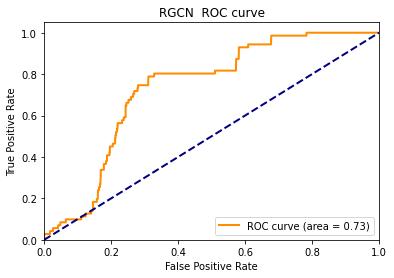

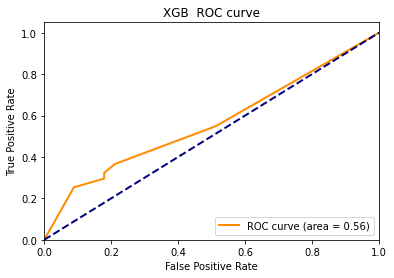

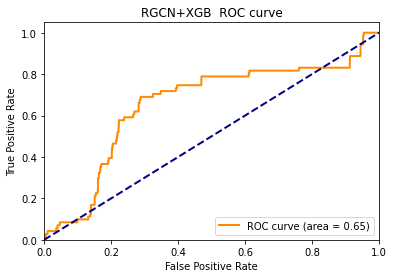

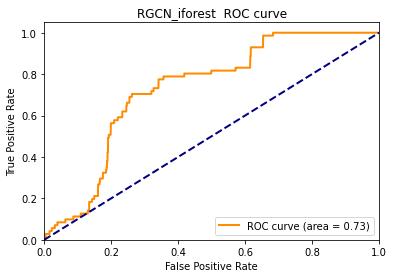

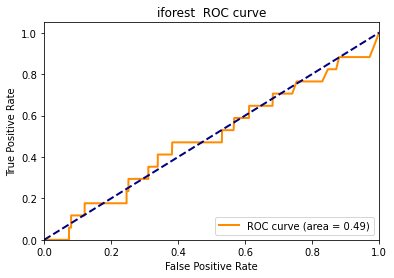

In [75]:
col_remove = meta_cols 
metrics_result = pd.DataFrame()
test_scores = test_data[meta_cols].copy()

print("Final Test Accuracy: {:.3f} auc {:.3f}".format(test_acc, test_auc))
# RGCN
acc, f1, precision, recall, roc_auc, pr_auc, ap, confusion_matrix, _ = get_metrics(
    test_logits.numpy(), fraud_labels[test_seeds], out_dir=result_dir, name='RGCN')


test_scores['rgcn'] = test_logits.numpy()[:,1]

# XGBoost
acc, f1, precision, recall, roc_auc, pr_auc, ap, confusion_matrix, pred_xgb, roc_xgg = baseline_models(
    train_x=train_data.drop(col_remove, axis=1), test_x=test_data.drop(col_remove, axis=1),
    train_idx=train_idx, test_idx=test_idx, labels=labels.cpu().numpy() ,
    test_label=fraud_labels, name='XGB')

test_scores['xgb'] = pred_xgb

# RGCN+XGBoost
acc, f1, precision, recall, roc_auc, pr_auc, ap, confusion_matrix, pred_rgcn_xgb, _ = baseline_models(
    train_x=train_embedding.cpu().numpy(),
    test_x=test_embedding.cpu().numpy(), 
    train_idx=train_seeds,
    test_idx=test_seeds,
    labels=labels.cpu().numpy(),
    test_label=fraud_labels,
    name='RGCN+XGB')

test_scores['rgcn_xgb'] = pred_rgcn_xgb

# rgcn + iforest
acc, f1, precision, recall, roc_auc, pr_auc, ap, confusion_matrix, pred_rgcn_if, roc_rgcniff = unsupervised_models(
    train_x=train_embedding.cpu().numpy(), test_x=test_embedding.cpu().numpy(), 
    train_idx=train_seeds, test_idx=test_seeds,
     labels=labels.cpu().numpy(),
     test_label=fraud_labels, name='RGCN_iforest')

test_scores['rgcn_if'] = pred_rgcn_if

#iforest
acc, f1, precision, recall, roc_auc, pr_auc, ap, confusion_matrix, iff_scores,_ = unsupervised_models(
    train_x=train_data.drop(col_remove, axis=1), test_x=test_data.drop(col_remove, axis=1), 
    train_idx=train_data.index, test_idx=test_data.reset_index().index,
     labels=test_data.fraud_label,
     test_label=fraud_labels, name='iforest')


In [153]:
# save summary statistics
#pd.DataFrame(metrics_result).to_csv(os.path.join(result_dir, "metrics_azure-if_status_flag_V57.csv"))

### Result comparison
Compare model performance against baseline models.

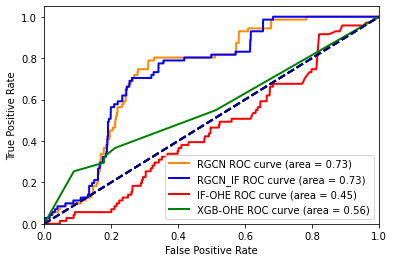

In [76]:
def roc_cr(fpr, tpr,  model_name='Model', color='darkorange'):
    
    lw = 2
    roc_auc = roc_auc_score(fpr, tpr)
    fpr, tpr, _ = roc_curve(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color,
             lw=lw, label=model_name+' ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title(model_name +'  ROC curve')
    plt.legend(loc="lower right")

f = plt.figure()
roc_cr(test_scores.fraud_label, test_scores['rgcn'], model_name='RGCN')
roc_cr(test_scores.fraud_label, test_scores['rgcn_if'], color='blue', model_name='RGCN_IF')
roc_cr(test_scores.fraud_label, iff_scores, color='red', model_name='IF-OHE')
roc_cr(test_scores.fraud_label, pred_xgb, color='green', model_name='XGB-OHE')

In [30]:
test_scores.head(5)

,day,fraud_label,appId_id,userId_id,ipAddress_id,auth_id,status_flag,rgcn,xgb,rgcn_xgb,rgcn_if
0,58,0,0,0,0,0,0,0.461083,0.000017,0.303696,0.363868
4,52,0,0,2,4,4,1,0.555658,0.999754,0.966817,0.530296
10,53,0,0,2,10,10,1,0.554542,0.999754,0.962133,0.530574
12,54,0,0,2,12,12,1,0.858610,0.999754,0.983580,0.747158
14,53,0,0,2,14,14,1,0.554503,0.999754,0.970992,0.529860


### Save model for inference

In [157]:
# Save model
save_model(g, model, "modeldir/")

### Result analysis
#### Grouping user scores across authentication.

In [123]:
grouped_users = test_scores.groupby(['userId_id','day']).agg({'rgcn':np.median, 'fraud_label':'max', 'status_flag':'max', 'rgcn_if':np.median
                                                          }).reset_index().sort_values(['rgcn_if'], ascending=False)

In [124]:
grouped_users[grouped_users.fraud_label==1]

,userId_id,day,rgcn,fraud_label,status_flag,rgcn_if
1369,121,51,0.574613,1,1,0.661473
1319,117,49,0.473802,1,1,0.415689
1365,121,47,0.476024,1,1,0.402190
1366,121,48,0.462354,1,1,0.396483
1321,117,51,0.468351,1,1,0.395271
1320,117,50,0.466868,1,0,0.392660
1317,117,47,0.465617,1,0,0.391830
1367,121,49,0.429801,1,1,0.390257
1368,121,50,0.428881,1,1,0.385148
1318,117,48,0.448088,1,1,0.377138


#### Top $K$ number of users per day

Generate scores of Top K users per day.

Precision at top $K=20$ for each model with detected $userId$

In [64]:
model_names = ['rgcn', 'xgb', 'rgcn_xgb', 'rgcn_if']
for model_name in model_names:
    print(model_name , precision_top_k_day(test_scores, 20, model_name))

rgcn ([121, 117], 0.1)
xgb ([121], 0.05)
rgcn_xgb ([121], 0.05)
rgcn_if ([121], 0.05)


We can also get detected users for each day on top $k$. In this case we are able to see flagged users in day 45, 54-55 & 59

In [69]:
uprs = []
frame_prec = pd.DataFrame()
for model_name in model_names:
    _, _, _, u_pr = user_precision_top_k(test_scores, 40, model_name)
    temp = pd.DataFrame({'day':test_scores.day.unique()})
    temp['model_name'] = model_name
    temp[['users','prec']] = pd.json_normalize(u_pr.values())
    frame_prec = pd.concat([frame_prec, temp])
frame_prec_wide = frame_prec.pivot(index='day', columns='model_name', values='users')

In [73]:
# For RGCN
frame_prec_wide['rgcn']

day
44            []
45    [121, 117]
46            []
47            []
48            []
49            []
50            []
51    [121, 117]
52            []
53            []
54    [121, 117]
55    [117, 121]
56            []
57            []
58            []
59    [117, 121]
Name: rgcn, dtype: object

In [77]:
# For RGCN_IF
frame_prec_wide['rgcn_if']

day
44            []
45         [121]
46            []
47            []
48            []
49            []
50            []
51    [121, 117]
52            []
53            []
54         [121]
55         [117]
56            []
57            []
58            []
59         [117]
Name: rgcn_if, dtype: object

#### Show top 10 ranked users per day for the last 7 days.

In [78]:
top_100_users = pd.DataFrame()
for day in test_scores.day.unique():
    top_100_users = pd.concat([top_100_users,
                               test_scores[test_scores.day==day].
                               sort_values(['rgcn'], ascending=False).head(100)
                              ])

Get list of users & application Id for a given day. 

In [79]:
day = 48
top_users_last_day = test_scores[test_scores.day==day].sort_values(['rgcn'], ascending=False)[[
    'userId_id','appId_id','fraud_label', 'status_flag','rgcn', 'rgcn_if'
]]
top_users_last_day.head(10)

,userId_id,appId_id,fraud_label,status_flag,rgcn,rgcn_if
12306,121,35,1,1,0.914227,0.753835
2136,121,0,1,1,0.913817,0.753835
53068,117,242,1,1,0.838932,0.734581
5404,117,1,1,0,0.814508,0.721394
53887,37,250,0,0,0.653989,0.656558
53303,34,243,0,0,0.608578,0.647067
14066,187,46,0,1,0.601002,0.543524
12294,121,35,1,1,0.594150,0.554208
2132,121,0,1,1,0.592892,0.541692
48864,34,191,0,0,0.590367,0.626796


### Conclusion

In this workflow we showed end-to-end worklfow for malicious azure detection using RGCN.
we explore methods of heterogeneous graph embedding for malicious sign-on detection of azure logs. This work adds two main contributions. First, adapting log authentication as GNN, allows us to learn a richer embedding of authentication on both structural and individual entities involved without much hand-crafted feature learning. Second, by modeling every “authentication” as a target node, the model avoids the challenge of depending on modeling temporal historical user login information. The experimental result shows, R-GCN prediction scores on authentication nodes have a promising result on overall detection performance and are better than the baseline isolation forest & XGBoost algorithm applied to the learned embedding vector of authentication nodes.


### Reference
1. https://docs.microsoft.com/en-us/azure/active-directory/reports-monitoring/concept-sign-ins
2. Liu, Ziqi, et al. “Heterogeneous Graph Neural Networks for Malicious Account Detection.” arXiv [cs.LG], 27 Feb. 2020, https://doi.org/10.1145/3269206.3272010. arXiv.
3. Lv, Mingqi, et al. “A Heterogeneous Graph Learning Model for Cyber-Attack Detection.” arXiv [cs.CR], 16 Dec. 2021, http://arxiv.org/abs/2112.08986. arXiv.
4. Schlichtkrull, Michael, et al. "Modeling relational data with graph convolutional networks." European semantic web conference. Springer, Cham, 2018
5. Rao, Susie Xi, et al. "xFraud: explainable fraud transaction detection." Proceedings of the VLDB Endowment 3 (2021)
6. Powell, Brian A. "Detecting malicious logins as graph anomalies." Journal of Information Security and Applications 54 (2020): 102557